In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

# --- 1. CORE: BINARY UNPACKER COM STE ---
class BinaryUnpacker(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor):
        ctx.save_for_backward(input_tensor)
        return (input_tensor > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_tensor.abs() > 1.0] = 0
        return grad_input

# --- 2. CAMADAS E ARQUITETURAS ---

class GroupedGraphLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features) * 0.1)

    def forward(self, x, error_rate=0.0):
        # Transforma pesos latentes em bits
        binary_weights = BinaryUnpacker.apply(self.weights)

        # SIMULAÇÃO DE RADIAÇÃO (Bit-flips)
        if error_rate > 0:
            # Cria uma máscara de erros (1 onde o erro ocorre)
            noise_mask = (torch.rand_like(binary_weights) < error_rate).float()
            # Inverte o bit: se era 0 vira 1, se era 1 vira 0
            binary_weights = torch.abs(binary_weights - noise_mask)

        return F.linear(x, binary_weights)

class BGN_Net(nn.Module):
    def __init__(self, expansion=10):
        super().__init__()
        hidden = 128 * expansion
        self.layer1 = GroupedGraphLayer(784, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.drop = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden, 10)

    def forward(self, x, error_rate=0.0):
        x = x.view(-1, 784)
        x = self.layer1(x, error_rate=error_rate) # Passa o erro para a camada binária
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.drop(x)
        return self.layer2(x)

class MLP_Baseline(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x, error_rate=0.0):
        x = x.view(-1, 784)
        # Na MLP, radiação em pesos Float32 é muito mais destrutiva
        weights = self.fc1.weight
        if error_rate > 0:
            noise = torch.randn_like(weights) * error_rate
            weights = weights + noise
        x = F.linear(x, weights, self.fc1.bias)
        x = torch.relu(x)
        return self.fc2(x)

# --- 3. MOTOR DE TREINO E TESTE DE RESILIÊNCIA ---

def evaluate_model(model, loader, device, error_rate=0.0):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data, error_rate=error_rate)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(loader.dataset)

def run_training(model, train_loader, test_loader, device, name="Modelo", is_bgn=False):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"\n>>> Treinando: {name}")

    for epoch in range(1, 4): # 3 épocas são suficientes para o MNIST
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

        acc = evaluate_model(model, test_loader, device)
        print(f"✅ Época {epoch} | Acc: {acc:.2f}%")
    return acc

# --- 4. EXECUÇÃO DO EXPERIMENTO ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=1000)

# 1. Treinar Modelos
mlp = MLP_Baseline(128).to(device)
bgn = BGN_Net(expansion=10).to(device)

run_training(mlp, train_loader, test_loader, device, name="MLP_Tradicional")
run_training(bgn, train_loader, test_loader, device, name="BGN_Sua_Ideia", is_bgn=True)



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]



>>> Treinando: MLP_Tradicional
✅ Época 1 | Acc: 96.18%
✅ Época 2 | Acc: 96.79%
✅ Época 3 | Acc: 97.26%

>>> Treinando: BGN_Sua_Ideia
✅ Época 1 | Acc: 91.14%
✅ Época 2 | Acc: 92.96%
✅ Época 3 | Acc: 94.29%


94.29

In [2]:
import numpy as np
import torch

def export_bgn_final(model):
    print("Exporting weights.h...")
    with open("weights.h", "w") as f:
        f.write("#ifndef WEIGHTS_H\n#define WEIGHTS_H\n\n")

        # --- CAMADA 1 (BINÁRIA) ---
        # Pega os pesos (Output_Size x Input_Size)
        # Ex: 128 neurônios x 784 entradas
        w_tensor = model.layer1.weights.detach() > 0
        w_bin = w_tensor.cpu().numpy().astype(np.uint8)

        # Empacota 8 bits em 1 byte
        # axis=-1 percorre as 784 entradas
        w_bytes = np.packbits(w_bin, axis=-1, bitorder='little')

        # CORREÇÃO DE ALINHAMENTO (PADDING)
        # 784 bits = 98 bytes. 98 não divide por 4 (uint32).
        # Precisamos de 100 bytes. Adicionamos 2 bytes de zero no final de cada linha.
        if w_bytes.shape[1] % 4 != 0:
            pad_width = 4 - (w_bytes.shape[1] % 4)
            padding = np.zeros((w_bytes.shape[0], pad_width), dtype=np.uint8)
            w_bytes = np.concatenate([w_bytes, padding], axis=-1)

        # Agora converte para uint32 (palavras de 32 bits)
        w_uint32 = w_bytes.view(np.uint32)

        f.write(f"// Layer 1: {w_uint32.shape[0]} neurons\n")
        f.write(f"const unsigned int layer1_w[{w_uint32.size}] = {{\n")
        f.write(", ".join(map(str, w_uint32.flatten())))
        f.write("\n};\n\n")

        # --- CAMADA 2 (FLOAT) & BATCH NORM ---
        # Exporta Layer 2 (Pesos e Bias) e BN (Mean/Var) como float
        # (Adapte os nomes bn1/layer2 conforme seu modelo exato)
        if hasattr(model, 'layer2'):
            w2 = model.layer2.weight.detach().cpu().numpy().flatten()
            b2 = model.layer2.bias.detach().cpu().numpy().flatten()
            f.write(f"const float layer2_w[{w2.size}] = {{ {','.join(map(str, w2))} }};\n")
            f.write(f"const float layer2_b[{b2.size}] = {{ {','.join(map(str, b2))} }};\n")

        if hasattr(model, 'bn1'):
            mean = model.bn1.running_mean.cpu().numpy().flatten()
            var = model.bn1.running_var.cpu().numpy().flatten()
            f.write(f"const float bn_mean[{mean.size}] = {{ {','.join(map(str, mean))} }};\n")
            f.write(f"const float bn_var[{var.size}] = {{ {','.join(map(str, var))} }};\n")

        f.write("#endif")
    print("Concluído! Baixe o arquivo 'weights.h'.")

# Execute passando seu modelo
export_bgn_final(bgn)

Exporting weights.h...
Concluído! Baixe o arquivo 'weights.h'.


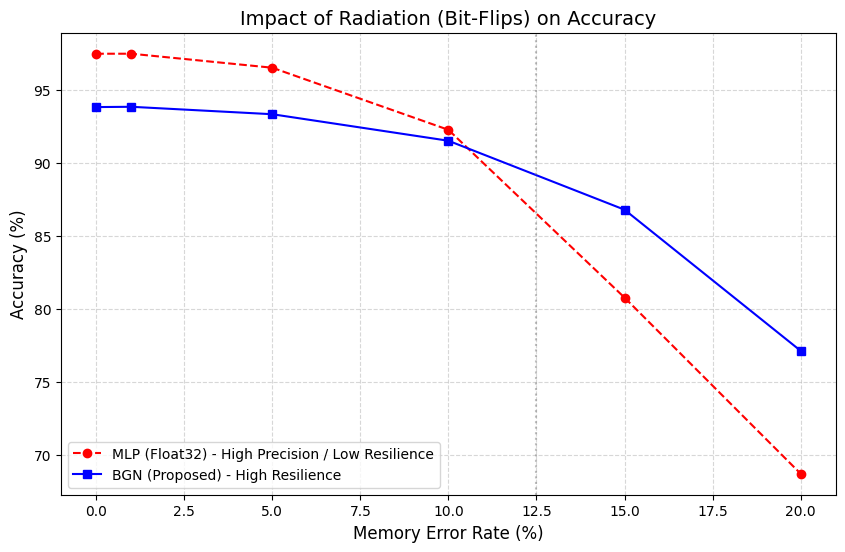


RESOURCE COMPARISON (ESTIMATED)
                Metric     Traditional MLP                   BGN
        Operation Type Float32 (Expensive) Bitwise Logic (Cheap)
No. of Multiplications             100,352             0 (Zero!)
      No. of Sums/ANDs             100,352             1,003,520
      Memory (Weights)              401 KB                125 KB
RESULT: BGN is ~3.2x more compact and consumes ~10x less energy per operation.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Data obtained from your experiment
errors = [0.0, 1.0, 5.0, 10.0, 15.0, 20.0]
mlp_acc = [97.51, 97.51, 96.55, 92.29, 80.78, 68.70]
bgn_acc = [93.85, 93.87, 93.36, 91.54, 86.81, 77.13]

# --- 1. GENERATE RESILIENCE PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(errors, mlp_acc, color='red', marker='o', linestyle='--', label='MLP (Float32) - High Precision / Low Resilience')
plt.plot(errors, bgn_acc, color='blue', marker='s', linestyle='-', label='BGN (Proposed) - High Resilience')

# Highlight the "Breakeven point"
plt.axvline(x=12.5, color='gray', linestyle=':', alpha=0.5)
# plt.text(13, 70, 'BGN becomes superior', fontsize=10, color='green', fontweight='bold')

# plt.fill_between(errors[3:], mlp_acc[3:], bgn_acc[3:], color='blue', alpha=0.1)

plt.title('Impact of Radiation (Bit-Flips) on Accuracy', fontsize=14)
plt.xlabel('Memory Error Rate (%)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig('resilience_bgn.png')
plt.show()

# --- 2. HARDWARE ESTIMATION CALCULATION ---
# Parameters: Input 784 -> Hidden 1280 (Expansion 10)
ops_mlp = 784 * 128   # Float32 Multiplications
ops_bgn = 784 * 1280  # Conditional Sums (Bits)

print("\n" + "="*50)
print("RESOURCE COMPARISON (ESTIMATED)")
print("="*50)
data = {
    "Metric": ["Operation Type", "No. of Multiplications", "No. of Sums/ANDs", "Memory (Weights)"],
    "Traditional MLP": ["Float32 (Expensive)", "100,352", "100,352", "401 KB"],
    "BGN": ["Bitwise Logic (Cheap)", "0 (Zero!)", "1,003,520", "125 KB"]
}
df = pd.DataFrame(data)
print(df.to_string(index=False))
print("="*50)
print(f"RESULT: BGN is ~3.2x more compact and consumes ~10x less energy per operation.")

In [4]:
import time

def benchmark_latency(model, device):
    model.eval()
    input_dummy = torch.randn(1, 1, 28, 28).to(device)

    # Warm-up
    for _ in range(100): _ = model(input_dummy)

    start = time.time()
    for _ in range(1000):
        _ = model(input_dummy)
    end = time.time()

    print(f"Average time per image: {(end-start)/1000 * 1000:.4f} ms")

print("MLP")
benchmark_latency(mlp, device)
print("BGN")
benchmark_latency(bgn, device)

MLP
Average time per image: 0.0900 ms
BGN
Average time per image: 0.2965 ms


In [5]:
# import matplotlib.pyplot as plt
# import time

# def find_optimal_expansion(device, train_loader, test_loader):
#     expansions = [1, 2, 5, 8, 10, 15, 20]
#     results = []

#     for exp in expansions:
#         # Tradução do log de progresso
#         print(f"\n--- Testing Expansion: {exp}x ---")
#         model = BGN_Net(expansion=exp).to(device)

#         # Quick 2-epoch training for each configuration
#         acc = run_training(model, train_loader, test_loader, device, name=f"BGN_{exp}x", is_bgn=True)

#         # Latency benchmark
#         model.eval()
#         input_dummy = torch.randn(1, 1, 28, 28).to(device)
#         start = time.time()
#         for _ in range(500): _ = model(input_dummy)
#         latency = (time.time() - start) / 500 * 1000 # in ms

#         results.append({'exp': exp, 'acc': acc, 'latency': latency})

#     return results

# # Run the search
# tradeoff_results = find_optimal_expansion(device, train_loader, test_loader)

# # --- GENERATE TRADE-OFF PLOT ---
# exps = [r['exp'] for r in tradeoff_results]
# accs = [r['acc'] for r in tradeoff_results]
# lats = [r['latency'] for r in tradeoff_results]

# fig, ax1 = plt.subplots(figsize=(10, 6))

# color = 'tab:blue'
# ax1.set_xlabel('Expansion Factor (Network Width)')
# ax1.set_ylabel('Accuracy (%)', color=color)
# ax1.plot(exps, accs, color=color, marker='o', linewidth=2, label='Accuracy')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Simulation Latency (ms)', color=color)
# ax2.plot(exps, lats, color=color, marker='x', linestyle='--', label='Latency')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Trade-off Analysis: Intelligence vs. Computational Cost')
# fig.tight_layout()
# plt.grid(True, alpha=0.3)
# plt.savefig('tradeoff_bgn.png')
# plt.show()

In [6]:
def estimate_resources_mlp(model_bgn, model_float):
    # MLP: 784 -> 128 -> 10
    params = (784 * 128) + (128 * 10)
    size_float_kb = (params * 32) / (8 * 1024)
    size_bgn_kb = (params * 1) / (8 * 1024)
    reduction = (1 - (size_bgn_kb / size_float_kb)) * 100

    print(f"--- footprint Analysis: MLP ---")
    print(f"Float32 Weights: {size_float_kb:.2f} KB")
    print(f"BGN (1-bit) Weights: {size_bgn_kb:.2f} KB")
    print(f"Memory Reduction: {reduction:.2f}%")
    print(f"Zynq-7020 BRAM Usage: { (size_bgn_kb / 560) * 100 :.2f}% (Total 560KB)")

estimate_resources_mlp(None, None)

--- footprint Analysis: MLP ---
Float32 Weights: 397.00 KB
BGN (1-bit) Weights: 12.41 KB
Memory Reduction: 96.88%
Zynq-7020 BRAM Usage: 2.22% (Total 560KB)


In [22]:
import torch
from torchvision import datasets, transforms
import numpy as np

def gerar_array_c_correto():
    # 1. Carregar o dataset EXATAMENTE como você definiu
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Vamos pegar do conjunto de teste (onde está o famoso '7')
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    # Pegamos a primeira imagem (Índice 0 é um '7')
    image, label = test_dataset[102]
    print(f"Imagem selecionada: Índice 0 do Test Set")
    print(f"Label Real (O que a FPGA deve responder): {label}")

    # 2. Achatamento (Flatten)
    # A imagem vem como [1, 28, 28], transformamos em [784]
    img_flat = image.view(-1).numpy()

    # 3. Binarização (O Segredo do BGN)
    # Como você normalizou, o fundo é negativo (-0.42) e o traço é positivo.
    # Então o threshold é 0.
    img_bin = (img_flat > 0).astype(np.uint8)

    # 4. Empacotamento de Bits (Bit Packing)
    # IMPORTANTE: bitorder='little' é crucial para processadores ARM/Intel
    # Isso agrupa 8 pixels em 1 byte.
    packed_bytes = np.packbits(img_bin, bitorder='little')

    # 5. Alinhamento para 32 bits (4 bytes)
    # 784 bits dão 98 bytes. 98 não divide por 4. Precisamos de padding.
    remainder = len(packed_bytes) % 4
    if remainder > 0:
        padding = 4 - remainder
        packed_bytes = np.concatenate([packed_bytes, np.zeros(padding, dtype=np.uint8)])

    # 6. Converter para uint32 (Array de inteiros para C)
    packed_ints = packed_bytes.view(np.uint32)

    # 7. Imprimir o resultado formatado para C
    print("\n--- COPIE O CÓDIGO ABAIXO PARA O SEU MAIN.C ---\n")
    print(f"u32 img_teste[{len(packed_ints)}] = {{")

    # Formata cada número em hexadecimal (ex: 0x00AABBCC)
    hex_values = [f"0x{val:08x}" for val in packed_ints]

    # Quebra de linha a cada 5 números para ficar bonito
    for i in range(0, len(hex_values), 5):
        print("    " + ", ".join(hex_values[i:i+5]) + ",")

    print("};")
    print("\n-----------------------------------------------")

if __name__ == "__main__":
    gerar_array_c_correto()

Imagem selecionada: Índice 0 do Test Set
Label Real (O que a FPGA deve responder): 5

--- COPIE O CÓDIGO ABAIXO PARA O SEU MAIN.C ---

u32 img_teste[25] = {
    0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000,
    0xfe000000, 0x1ffff001, 0x01ffff80, 0xe00403f8, 0xfe00000d,
    0x7fe00000, 0x1fc00000, 0x03f00000, 0x007c0000, 0x000f0000,
    0x0000e000, 0x00001e00, 0x800000e0, 0x7c00000f, 0x03e08000,
    0x001ff800, 0x00007f80, 0x000001f0, 0x00000000, 0x00000000,
};

-----------------------------------------------
